In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
import os

from IPython import display
%matplotlib inline

import pickle

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tqdm import tqdm, tqdm_notebook
import time

In [3]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [5]:
def plot_group(*args, s = 7):
    n = len(args) // 2
    
    plt.figure(figsize=(s,s))
    f, a = plt.subplots(1, n,figsize=(s,s))
    #f.set_figsize((s,s))
    for i in range(n):
        im = args[2*i]
        if args[2*i + 1]:
            im = np.log(im + 1)
        a[i].imshow(im)

    plt.show()

In [6]:
def normalize(X, axis = 1):
    sums = X.sum(axis)
    sums[sums == 0] = 1
    D = np.diag(1 / np.sqrt(sums))
    
    return np.dot(np.dot(D, X), D)

In [9]:
def normalize_left(X, axis = 1):
    sums = X.sum(axis)
    sums[sums == 0] = 1
    D = np.diag(1 / sums)
    
    return np.dot(D, X)

In [10]:
def normalize_right(X, axis = 1):
    sums = X.sum(axis)
    sums[sums == 0] = 1
    D = np.diag(1 / sums)
    
    return np.dot(X, D)

In [11]:
def normalize_arr(X,normalizer, axis = 1):
    X_n = np.zeros_like(X)
    for i, x in enumerate(X):
        X_n[i] = normalizer(x, axis)
    return X_n

In [326]:
#X = np.save("../../data/simulation/1000_35_like_true/populations", synthetic_populations)
y = np.load("../data/simulation/1000_35_like_true/populations_gr.npy")[:, :32, :32]
X = np.load("../data/simulation/1000_35_like_true/amp_gr.npy")[:, :32, :32] 
#json.dump(params, open("../../data/simulation/1000_35_like_true/params.json", 'w'))

In [447]:
#X = np.save("../../data/simulation/1000_35_like_true/populations", synthetic_populations)
X = np.load("./X.npy")[:, :32, :32]
y = np.load("./Y.npy")[:, :32, :32] 
#json.dump(params, open("../../data/simulation/1000_35_like_true/params.json", 'w'))

In [448]:
def process_x(X):
    if len(X.shape) == 2:
        X = np.expand_dims(X, 0)
    
    #X = np.log(X + 1) / np.log(X + 1).max()
    X_list = []
    for nrmlzr in [normalize, normalize_left, normalize_right]:
        for i in [1]:
            X_list.append(np.expand_dims(normalize_arr(X, nrmlzr, i), 1))
    X = np.expand_dims(X, 1)
    
    #X_list.append(np.log(X + 1) / np.log(X + 1).max())
    #X_list.append(X)
    
    return np.transpose(np.concatenate(X_list, 1), [0,2,3,1])

In [449]:
X_p = process_x(X)

In [450]:
X_p[:,:,:,2].max()

19.0

In [451]:
def norm(x):
    maxes = x.max(2)
    maxes[maxes == 0] = 1
    #print(maxes.astype(int))
    return x / maxes.reshape(x.shape[0], x.shape[1], 1)

In [452]:
#X_n = normalize_arr(X)
y_n = (y > 0).astype(int)

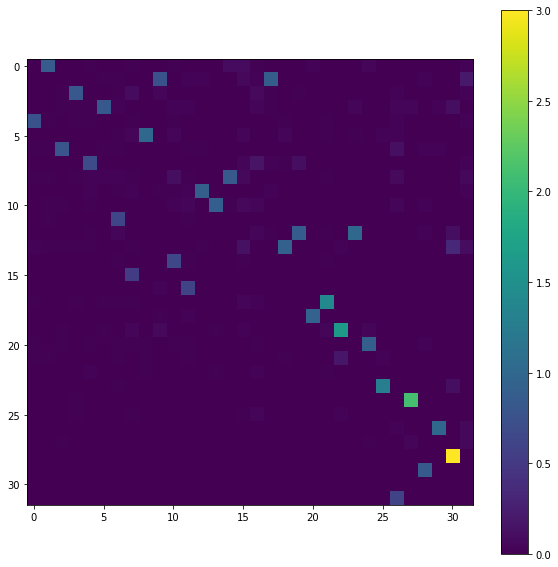

In [453]:
plot_gr(X_p[0,:,:,2], log = 0)

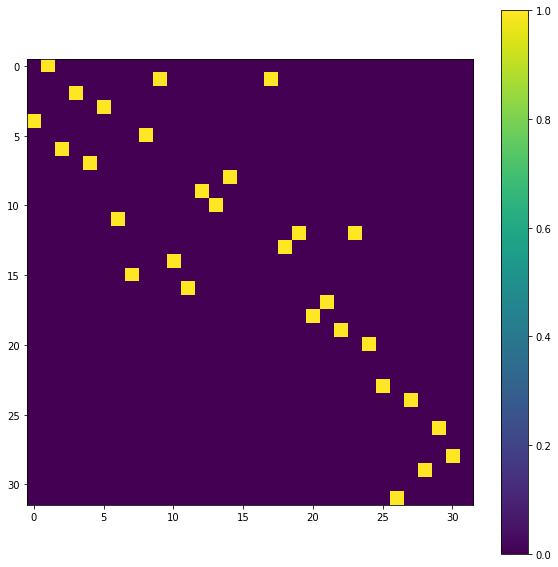

In [454]:
plot_gr(y_n[0])

In [455]:
def iterate_minibatches(x, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, x.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt], y[excerpt]

In [456]:
def get_Unet(name, shape):
    with tf.variable_scope(name) as scope:
        x = tf.placeholder("float", shape=[None, None, None, shape])
        c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (x)
        c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
        p1 = MaxPooling2D((2, 2)) (c1)

        c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
        c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
        c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
        p3 = MaxPooling2D((2, 2)) (c3)

        c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
        c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

        c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
        c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

        u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
        c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

        u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
        c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

        u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
        c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

        u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
        c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

        out = Conv2D(1, (1, 1), activation='sigmoid') (c9)
        
        target = tf.placeholder("float", shape=[None, None, None, 1])
        loss_mask = tf.placeholder("float", shape=[None, None, None, 1])
        
        loss = tf.reduce_mean(tf.losses.log_loss(target, out, weights = loss_mask))
        
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta2=0.98)
        train_step = optimizer.minimize(loss)
        
    return Unet(scope, x, out, target, loss, loss_mask, train_step)

In [457]:
class Unet:
    def __init__(self, scope, x, out, target, loss, loss_mask, train_step):
        self.scope = scope
        self.x = x
        self.out = out
        self.target = target
        self.loss = loss
        self.loss_mask = loss_mask,
        self.train_step = train_step

In [481]:
tf.reset_default_graph()
sess = tf.Session()

In [482]:
Unets = []

In [483]:
Unets.append(get_Unet("0", 3))

In [484]:
uninitialized_vars = []
for var in tf.all_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)

init_new_vars_op = tf.initialize_variables(uninitialized_vars)
sess.run(init_new_vars_op)

In [485]:
train_loss = []
val_scores = []
val_loss = []

In [486]:
epochs = 10
l_r = 0.001

In [487]:
batch_w.shape

(20, 32, 32, 1)

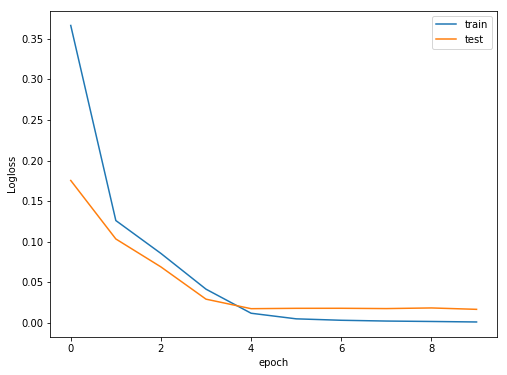

In [488]:
U_ind = 0
s, e = 0,3
for epoch in range(epochs):
    curr_loss = 0
    for i, (batch_x, batch_y) in tqdm(enumerate(iterate_minibatches(X_p[:700], y_n[:700], 20))):
        batch_w = np.expand_dims(np.ones_like(batch_y), 3)
        #batch_w = np.expand_dims((batch_y > 0.).astype(float) * (batch_y == 0).sum() + (batch_y == 0).astype(float) * (batch_y != 0).sum(), 3)
#         batch_x = np.expand_dims(batch_x, 3)
        batch_y = np.expand_dims(batch_y, 3)
        batch_loss = sess.run([Unets[U_ind].train_step,Unets[U_ind].loss], feed_dict={Unets[U_ind].x : batch_x[:,:,:,s:e],
                                                            Unets[U_ind].target: batch_y,
                                                            Unets[U_ind].loss_mask: batch_w,
                                                            })
        curr_loss += batch_loss[1]
        #print(curr_loss)

    train_loss.append(curr_loss / (i + 1)) 
    
#     val_score = validate_simple(val_data, predict)            
#     val_scores.append(val_score)
    
    
    
    curr_loss = 0
    for i, (batch_x, batch_y) in tqdm(enumerate(iterate_minibatches(X_p[700:850], y_n[700:850], 20))):
#         batch_x = np.expand_dims(batch_x, 3)
        batch_w = np.expand_dims(np.ones_like(batch_y),3)
        #batch_w = np.expand_dims((batch_y > 0.).astype(float) * (batch_y == 0).sum() + (batch_y == 0).astype(float) * (batch_y != 0), 3)
        batch_y = np.expand_dims(batch_y, 3)
        batch_loss = sess.run([Unets[U_ind].loss], feed_dict={Unets[U_ind].x : batch_x[:,:,:,s:e],
                                                 Unets[U_ind].target: batch_y,
                                                 Unets[U_ind].loss_mask: batch_w,
                                                 })
        curr_loss += batch_loss[0]
        #print(curr_loss)

    val_loss.append(curr_loss / (i + 1))
    
    
    #val_loss.append(sess.run(loss, feed_dict={x:X_n, target:val_y, loss_mask:val_mask}))
   
    display.clear_output(wait=True)
    plt.figure(figsize = (8,6))
    plt.plot(train_loss, label='train')
    #plt.plot(val_scores, label='test')
    plt.plot(val_loss, label='test')

    plt.xlabel("epoch")
    plt.ylabel("Logloss")
    plt.legend()
    plt.show()
            

In [523]:
9/7

1.2857142857142858

In [489]:
pred = sess.run(Unets[U_ind].out, feed_dict={Unets[U_ind].x : X_p[850:,:,:,s:e]})[:,:,:,0]

In [490]:
#plot_group(pred[1], 0, y[801], 0, X[801], 1, X_p_n_p[801][:,:,0], 0, s = 16)

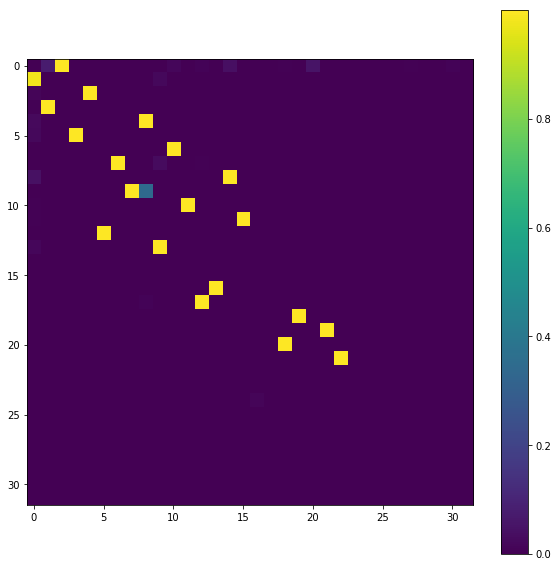

In [491]:
plot_gr(pred[1])

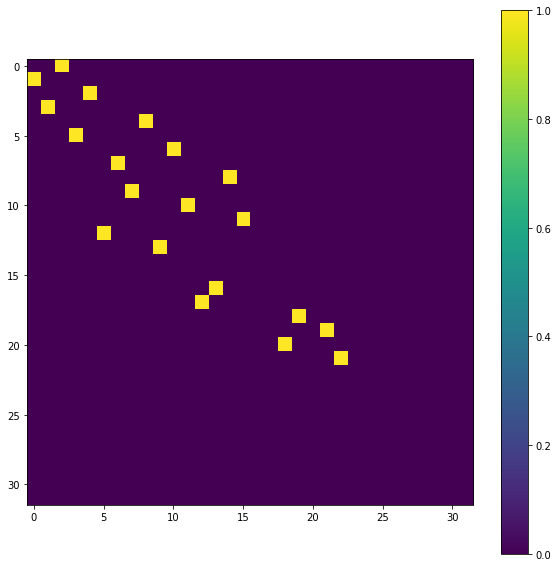

In [492]:
plot_gr(y_n[851])

In [493]:
from sklearn.metrics import roc_auc_score, f1_score,log_loss, accuracy_score, classification_report

In [494]:
log_loss(y_n[850:].reshape(150, -1), pred.reshape(150, -1))

117.74643712043762

In [495]:
# default unet default loss
f1_score(y_n[850:].flatten(), pred.flatten() > 0.5)

0.9614035087719298

In [496]:
# default unet default loss
print(classification_report(y_n[850:].flatten(), pred.flatten() > 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    149160
          1       1.00      0.93      0.96      4440

avg / total       1.00      1.00      1.00    153600



In [497]:
gr = np.load("../data/graphs/ES3_22.npy")[:32, :32]
#gr = np.load("../data/graphs/SlO_22_cut_at_10.npy")[:80, :80]

In [510]:
gr = np.load("../data/graphs/Sasha_22.npy")
#gr = np.load("../data/graphs/SlO_22_cut_at_10.npy")[:80, :80]

In [511]:
gr_p = process_x(gr)

In [512]:
es_pred = sess.run(Unets[U_ind].out, feed_dict={Unets[U_ind].x : gr_p[:,:,:,s:e]} )[0,:,:,0]

In [513]:
#es_pred1 = sess.run(Unets[1].out, feed_dict={Unets[1].x : gr_p[:,:,:,s:e]} )[0,:,:,0]

In [514]:
es_pred.shape

(80, 80)

In [515]:
(es_pred  > 0.5).sum()

5

In [516]:
pp = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
        [[4, 2, 5, 7, 11] for i in range(5)] + \
        [[4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
        [[1, 20, 22, 23, 21, 29]]

In [517]:
es_answ = np.zeros((35,35))

for p in pp:
    for a, b in zip(p, p[1:]):
        es_answ[a][b] = 1

In [518]:
np.where((((es_pred > 0.5).astype(int)) != es_answ[:32,:32]))

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([0]),)

In [519]:
es_pred[1, 20]

0.0

In [520]:
es_pred[4, 24]

0.0

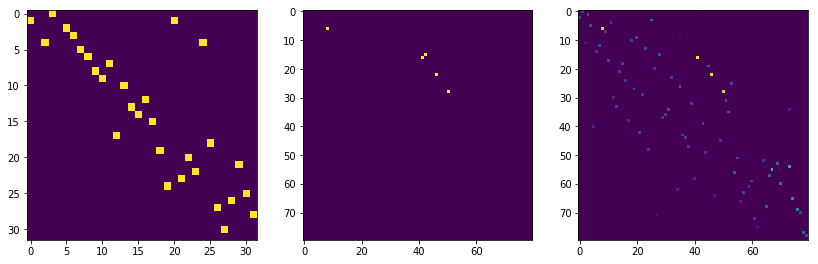

In [522]:
plot_group(es_answ[:32,:32] ,0,es_pred  ,0, gr_p[0,:,:,0], 1, s = 14)

In [509]:
gr_p[:,:,:,2].max()

305.90000000000003

In [268]:
import sys
sys.path.append("./h_module/")

In [269]:
import h_module.hamiltonian_path as hp

In [280]:
c = {}
hp.next_edge(gr, c)

25

In [281]:
c

{0: [74, 33, 77, 63, 37, 8, 7, 14, 15, 9, 16, 12, 11, 10, 13, 35, 56, 75, 44, 76, 53, 51, 70, 65, 61, 47, 34, 29, 22, 30, 20, 24, 43, 50, 79, 60, 67, 72, 54, 78, 52, 64, 73, 21, 62, 58, 19, 17, 18, 23, 57, 71, 42, 5, 3, 0, 2, 4, 1, 6, 32, 69, 28, 45, 68, 48, 36, 39, 46, 41, 59, 38, 26, 31, 27, 40, 66, 55, 49],
 17: [25, 25]}

In [282]:
c1 = {}
hp.next_edge((es_pred > 0.2).astype(int), c1)

24

In [287]:
w1 = []
for i, j in zip(c1[0].chain, c1[0].chain[1:]):
    w1.append(gr[i][j])

In [289]:
sum(w1)

7440.0

In [290]:
w = []
for i, j in zip(c[0].chain, c[0].chain[1:]):
    w.append(gr[i][j])

In [291]:
sum(w)

8600.0

In [299]:
c1[0].chain[:10]

[54, 52, 64, 78, 62, 19, 75, 32, 18, 23]

In [294]:
w1[:10]

[0.0, 78.0, 0.0, 0.0, 1.0, 3.0, 0.0, 5.0, 133.0, 108.0]

In [300]:
c[0].chain[:10]

[74, 33, 77, 63, 37, 8, 7, 14, 15, 9]

In [295]:
w[:10]

[68.0, 99.0, 0.0, 1.0, 5.0, 540.0, 210.0, 278.0, 228.0, 204.0]